## Group 13 - IDC 409 Term Project

Members:
* Tushar Baruah (MS19015)
* Atharva Hingane (MS19043)
* Nitish (MS19101)

### Project 1: Continuum Supression in HEP

We need to classify 'type' 0 and 1 in our data as signal and the others as background.

1. Our data has 59 independent parameters. We perform PCA to first reduce them.
2. We perform logistic regression to classify the data as signal or background.

data URL = <https://drive.google.com/file/d/1wceoRWDkqdXrAAt6x6Kuf9Dv3alW3iad/view?usp=drive_link>

GITHUB link = <https://github.com/TusharBaruah/Binary-Classification>

In [28]:
# Importing data and performing PCA

# data URL = https://drive.google.com/file/d/1wceoRWDkqdXrAAt6x6Kuf9Dv3alW3iad/view?usp=drive_link
# GITHUB link = https://github.com/TusharBaruah/Binary-Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Data = pd.read_csv('data_hep.csv')
Y_labels = Data['type'].to_numpy()

# re-labelling the data to signal (1) and background (0)
for i in range(0,len(Y_labels)):
    if(Y_labels[i]==0 or Y_labels[i]==1):
        Y_labels[i]=1.0 # signal
    else:
        Y_labels[i]=0.0 # background

Data = Data.drop('type',axis=1) # removing previous 'type' label
Data['type']=Y_labels # adding the signal and background label
X_set = Data.drop(columns=["Unnamed: 0","type"])
X_set = X_set.to_numpy()

pca= PCA(n_components=29)
result=pca.fit(X_set)
X_pca= result.transform(X_set)
print("Before PCA:",X_set.shape,"\nAfter PCA:",X_pca.shape)

PrecisionTestArray = []
PrecisionTrainArray = []
TestAccuracyArray = []
TrainAccuracyArray = []
RecallTestArray = []
RecallTrainArray = []
F1scoreTestArray = []
F1scoreTrainArray = []
TimeTaken = []
Models = ['Our LR', 'KNN','sklearn LR','SVM','DT']

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("Y_train:",Y_train.shape)
print("Y_test:",Y_test.shape)

Before PCA: (70606, 59) 
After PCA: (70606, 29)
X_train: (49424, 29)
X_test: (21182, 29)
Y_train: (49424,)
Y_test: (21182,)


In [29]:
# Performing Logistic Regression

import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math 

start = time.time()

def sigmoid(x):
    x = np.float64(x)
    y = 1 / (1 + np.exp(-x))
    return y

def our_log(input):
    if(input < 0.00000000001):
        return - 2**30
    else:
        return np.log(input)

# Function to compute cost  - using vectorization
def cost_logreg_vec(X, y, w, b):
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = sigmoid(z)
    loss_vec = np.array([- (y[i] * our_log(y_dash[i])) - ((1 - y[i]) * our_log(1 - y_dash[i])) for i in range(m)])
    #loss_vec = np.array([- (y[i] * np.log(y_dash[i])) - ((1 - y[i]) * np.log(1 - y_dash[i])) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    # cost = cost_func_vec(y, y_dash)
    return cost

def grad_logreg_vec(X, y, w, b): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    y_dash = sigmoid(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    
    return grad_w, grad_b

# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, learning_rate, n_iter, show_cost = True): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    cost_history, params_history = [], []

    for i in range(n_iter):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - learning_rate * grad_w
        b += - learning_rate * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and (i == n_iter - 1):
            print("Iteration",i,",Cost:",float(cost_history[i]))
        
    return w, b, cost_history, params_history


# Learning model parameters using gradient descent algorithm
a=np.zeros(X_train.shape[1])

w_out, b_out, cost_history, params_history = grad_desc(X_train,
                                                       Y_train,
                                                       a,
                                                       0,
                                                       learning_rate = 0.1,
                                                       n_iter = 250)

# Prediction and evaluation on the training set and the test set
y_train_prob = sigmoid(np.matmul(X_train, w_out) + (b_out * np.ones(X_train.shape[0])))
y_test_prob = sigmoid(np.matmul(X_test, w_out) + (b_out * np.ones(X_test.shape[0])))
y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)

end = time.time()
print("Time taken by the algorithm=",end-start,"seconds")
TimeTaken.append(end-start)

print("Training:\n",classification_report(Y_train, y_train_pred))
print("Testing:\n",classification_report(Y_test, y_test_pred))

cmTest = confusion_matrix(Y_test, y_test_pred)
print('Confusion matrix\n', cmTest)
print('True Positives(TP) = ', cmTest[0,0])
print('True Negatives(TN) = ', cmTest[1,1])
print('False Positives(FP) = ', cmTest[0,1])
print('False Negatives(FN) = ', cmTest[1,0])

cmTrain = confusion_matrix(Y_train, y_train_pred)

# calculate these and append to list
recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

PrecisionTestArray.append(precisionTest)
PrecisionTrainArray.append(precisionTrain)
TestAccuracyArray.append(testAccuracy)
TrainAccuracyArray.append(trainAccuracy)
RecallTestArray.append(recallTest)
RecallTrainArray.append(recallTrain)
F1scoreTestArray.append(f1scoreTest)
F1scoreTrainArray.append(f1scoreTrain)

Iteration 249 ,Cost: 0.399596715369734
Time taken by the algorithm= 38.98960852622986 seconds
Training:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82     24247
           1       0.82      0.83      0.83     25177

    accuracy                           0.82     49424
   macro avg       0.82      0.82      0.82     49424
weighted avg       0.82      0.82      0.82     49424

Testing:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82     10594
           1       0.82      0.83      0.82     10588

    accuracy                           0.82     21182
   macro avg       0.82      0.82      0.82     21182
weighted avg       0.82      0.82      0.82     21182

Confusion matrix
 [[8649 1945]
 [1789 8799]]
True Positives(TP) =  8649
True Negatives(TN) =  8799
False Positives(FP) =  1945
False Negatives(FN) =  1789


## Comparing with other existing models

K-nearest Neighbours

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)

start = time.time()
knn.fit(X_train, Y_train)
end = time.time()
print("Time taken by the algorithm=",end-start,"seconds")
TimeTaken.append(end-start)

y_test_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

cmTest = confusion_matrix(Y_test, y_test_pred)
print('Confusion matrix\n', cmTest)
print('True Positives(TP) = ', cmTest[0,0])
print('True Negatives(TN) = ', cmTest[1,1])
print('False Positives(FP) = ', cmTest[0,1])
print('False Negatives(FN) = ', cmTest[1,0])

cmTrain = confusion_matrix(Y_train, y_train_pred)

# calculate these and append to list
recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

PrecisionTestArray.append(precisionTest)
PrecisionTrainArray.append(precisionTrain)
TestAccuracyArray.append(testAccuracy)
TrainAccuracyArray.append(trainAccuracy)
RecallTestArray.append(recallTest)
RecallTrainArray.append(recallTrain)
F1scoreTestArray.append(f1scoreTest)
F1scoreTrainArray.append(f1scoreTrain)

Time taken by the algorithm= 0.007004976272583008 seconds
Confusion matrix
 [[8176 2418]
 [1520 9068]]
True Positives(TP) =  8176
True Negatives(TN) =  9068
False Positives(FP) =  2418
False Negatives(FN) =  1520


In-built logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
import time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)

start = time.time()
lr=LogisticRegression(max_iter=5000)
lr.fit(X_train, Y_train)
end = time.time()
print("Time taken by the algorithm=",end-start,"seconds")
TimeTaken.append(end-start)

y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

cmTest = confusion_matrix(Y_test, y_test_pred)
print('Confusion matrix\n', cmTest)
print('True Positives(TP) = ', cmTest[0,0])
print('True Negatives(TN) = ', cmTest[1,1])
print('False Positives(FP) = ', cmTest[0,1])
print('False Negatives(FN) = ', cmTest[1,0])

cmTrain = confusion_matrix(Y_train, y_train_pred)

# calculate these and append to list
recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

PrecisionTestArray.append(precisionTest)
PrecisionTrainArray.append(precisionTrain)
TestAccuracyArray.append(testAccuracy)
TrainAccuracyArray.append(trainAccuracy)
RecallTestArray.append(recallTest)
RecallTrainArray.append(recallTrain)
F1scoreTestArray.append(f1scoreTest)
F1scoreTrainArray.append(f1scoreTrain)

Time taken by the algorithm= 1.588076114654541 seconds
Confusion matrix
 [[8653 1941]
 [1507 9081]]
True Positives(TP) =  8653
True Negatives(TN) =  9081
False Positives(FP) =  1941
False Negatives(FN) =  1507


Support Vector Machine

In [32]:
from sklearn.svm import LinearSVC
import time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)

start = time.time()
svm=LinearSVC(C=0.0001)
svm.fit(X_train, Y_train)
end = time.time()
print("Time taken by the algorithm=",end-start,"seconds")
TimeTaken.append(end-start)

y_test_pred = svm.predict(X_test)
y_train_pred = svm.predict(X_train)

cmTest = confusion_matrix(Y_test, y_test_pred)
print('Confusion matrix\n', cmTest)
print('True Positives(TP) = ', cmTest[0,0])
print('True Negatives(TN) = ', cmTest[1,1])
print('False Positives(FP) = ', cmTest[0,1])
print('False Negatives(FN) = ', cmTest[1,0])

cmTrain = confusion_matrix(Y_train, y_train_pred)

# calculate these and append to list
recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

PrecisionTestArray.append(precisionTest)
PrecisionTrainArray.append(precisionTrain)
TestAccuracyArray.append(testAccuracy)
TrainAccuracyArray.append(trainAccuracy)
RecallTestArray.append(recallTest)
RecallTrainArray.append(recallTrain)
F1scoreTestArray.append(f1scoreTest)
F1scoreTrainArray.append(f1scoreTrain)

c:\Miniconda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Time taken by the algorithm= 3.097853183746338 seconds
Confusion matrix
 [[8618 1976]
 [1718 8870]]
True Positives(TP) =  8618
True Negatives(TN) =  8870
False Positives(FP) =  1976
False Negatives(FN) =  1718


Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)

start = time.time()
clf = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
clf.fit(X_train, Y_train)
end = time.time()
print("Time taken by the algorithm=",end-start,"seconds")
TimeTaken.append(end-start)

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

cmTest = confusion_matrix(Y_test, y_test_pred)
print('Confusion matrix\n', cmTest)
print('True Positives(TP) = ', cmTest[0,0])
print('True Negatives(TN) = ', cmTest[1,1])
print('False Positives(FP) = ', cmTest[0,1])
print('False Negatives(FN) = ', cmTest[1,0])

cmTrain = confusion_matrix(Y_train, y_train_pred)

# calculate these and append to list
recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

PrecisionTestArray.append(precisionTest)
PrecisionTrainArray.append(precisionTrain)
TestAccuracyArray.append(testAccuracy)
TrainAccuracyArray.append(trainAccuracy)
RecallTestArray.append(recallTest)
RecallTrainArray.append(recallTrain)
F1scoreTestArray.append(f1scoreTest)
F1scoreTrainArray.append(f1scoreTrain)

Time taken by the algorithm= 0.861525297164917 seconds
Confusion matrix
 [[8253 2341]
 [2843 7745]]
True Positives(TP) =  8253
True Negatives(TN) =  7745
False Positives(FP) =  2341
False Negatives(FN) =  2843


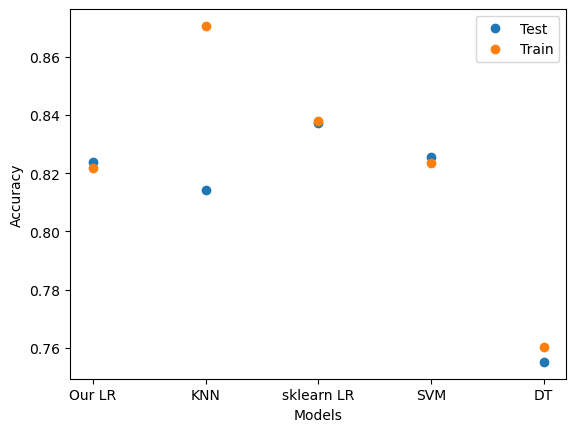

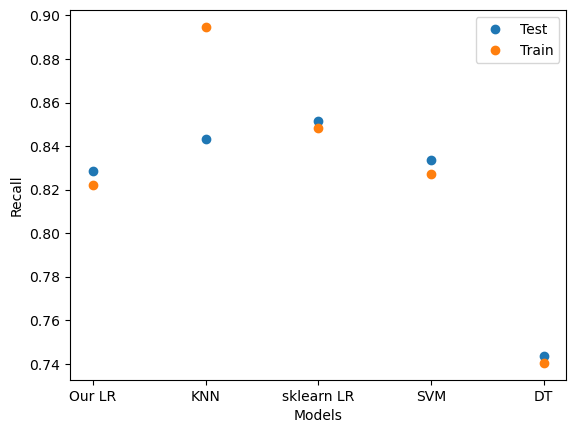

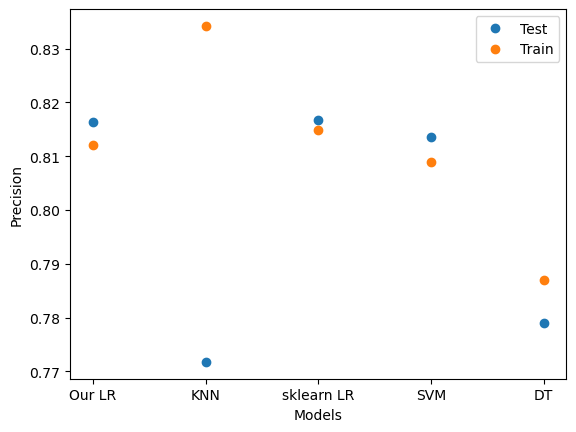

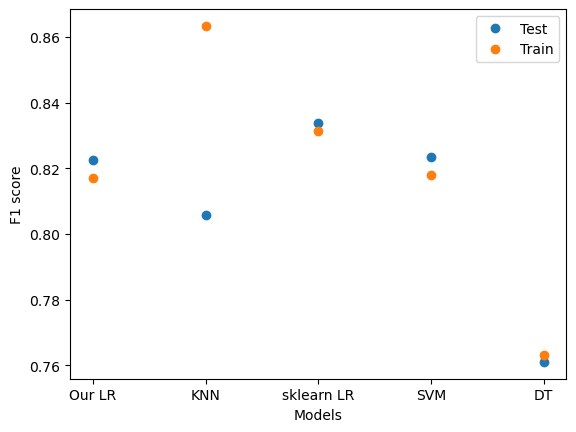

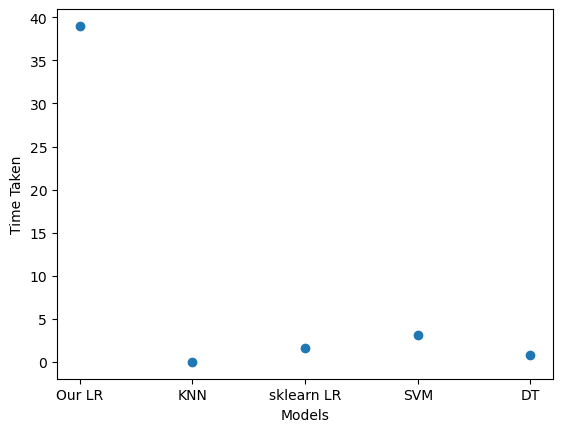

In [35]:
# plotting for different models
import matplotlib.pyplot as plt

# put a suitable location to save plots
location = 'E:/Studies/9th_semester_2023/IDC409_intro_DS/project/plots/'

plt.plot(Models,TestAccuracyArray,marker='o',ls='',label='Test')
plt.plot(Models,TrainAccuracyArray,marker='o',ls='',label='Train')
plt.xlabel('Models')
plt.ylabel('Accuracy')
# plt.ylim(0.81,1)
plt.legend()
plt.savefig(location+'accuracy_vs_models.pdf',bbox_inches='tight')
plt.show()

plt.plot(Models,RecallTestArray,marker='o',ls='',label='Test')
plt.plot(Models,RecallTrainArray,marker='o',ls='',label='Train')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.legend()
plt.savefig(location+'recall_vs_models.pdf',bbox_inches='tight')
plt.show()

plt.plot(Models,PrecisionTestArray,marker='o',ls='',label='Test')
plt.plot(Models,PrecisionTrainArray,marker='o',ls='',label='Train')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.legend()
plt.savefig(location+'precision_vs_models.pdf',bbox_inches='tight')
plt.show()

plt.plot(Models,F1scoreTestArray,marker='o',ls='',label='Test')
plt.plot(Models,F1scoreTrainArray,marker='o',ls='',label='Train')
plt.xlabel('Models')
plt.ylabel('F1 score')
plt.legend()
plt.savefig(location+'f1score_vs_models.pdf',bbox_inches='tight')
plt.show()

plt.plot(Models,TimeTaken,marker='o',ls='')
plt.xlabel('Models')
plt.ylabel('Time Taken')
plt.savefig(location+'timetaken_vs_models.pdf',bbox_inches='tight')
plt.show()